In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches


In [3]:
df = pd.read_csv('Data/Bins_data_sndry_min.csv')

gtdb_a = pd.read_csv('Data/gtdbtk.ar122.summary.tsv', sep = '\t')
gtdb_b = pd.read_csv('Data/gtdbtk.bac120.summary.tsv',sep = '\t')


In [4]:
## import the data from gtdbtk and fix it up
gtdb_a = pd.read_csv('Data/gtdbtk.ar122.summary.tsv', sep = '\t') # df for an archaea species
gtdb_b = pd.read_csv('Data/gtdbtk.bac120.summary.tsv',sep = '\t') # df for the bacterial species
gtdb = pd.concat([gtdb_a,gtdb_b])

##fix up the names of the sr bins to match other dataframes
## dict of old to new names (all are in the sr assrmbly)
sr_names_dict = {'cluster_DBSCAN_round1_1':'MH-Pat_SR_autometa_cluster_DBSCAN_round1_1',
 'cluster_DBSCAN_round3_0':'MH-Pat_SR_autometa_cluster_DBSCAN_round3_0',
 'cluster_DBSCAN_round2_1':'MH-Pat_SR_autometa_cluster_DBSCAN_round2_1',
 'cluster_DBSCAN_round4_1':'MH-Pat_SR_autometa_cluster_DBSCAN_round4_1',
 'bins.5':'MH-Pat_SR_metabat2_bins_bin.5',
 'bins.25':'MH-Pat_SR_metabat2_bins_bin.25'}

## Loop over and change the names
for name in gtdb['user_genome']:
    if name in sr_names_dict.keys():
        gtdb.loc[gtdb['user_genome']==name, 'user_genome'] = sr_names_dict[name]

## just get the useful columns
gtdb = gtdb[['user_genome', 'classification']].reset_index()

In [5]:
## process the taxonomy 

gtdb['phylum'] = gtdb['classification'].apply(lambda tax: tax.split(';')[1].split('_')[2])
gtdb['class'] = gtdb['classification'].apply(lambda tax: tax.split(';')[2].split('_')[2])

## Move proteo class over to phylum column
gtdb.loc[gtdb['phylum']=='Proteobacteria', 'phylum'] = gtdb['class']


## Map the equivalent SILVA to match
tax_remap = {'Acidobacteriota':'Acidobacteria',
 'Actinobacteriota':'Actinobacteria',
 'Bacteroidota':'Bacteroidetes',
  'Nitrospirota':'Nitrospirae'}

gtdb=gtdb.replace({"phylum": tax_remap})


In [6]:
## Make a cpoy of the DF to make changes to
df_copy = df.copy()

In [7]:
## Split proteo by A, B, G
df_copy.loc[df_copy['phylum']=='Proteobacteria', 'phylum'] = df_copy['class']

In [8]:
## Split out the A, B and G rows and sort
proteo = df_copy[df_copy['phylum'].isin(['Alphaproteobacteria','Gammaproteobacteria',])].sort_values(by='phylum')
## Sort the remaingin phluym Phyla
not_prot = df_copy[~df_copy['phylum'].isin(['Alphaproteobacteria','Gammaproteobacteria',])].sort_values(by='phylum')

In [9]:
stack = pd.concat([proteo,not_prot ], ignore_index=True)
stack['OG_ID'] = stack['OG_ID'].apply(lambda x: x-1)
stack = stack.set_index('bin_name')
##Drop the unused cols 
stack_to_map = stack.drop(columns=['class','OG_ID'])


In [26]:
stack_to_map.to_csv('Data/Bins_phylo_order.csv')

In [11]:
## added the 3 new gtdbtk  phyla to the color_map dict
color_map = {'Alphaproteobacteria':"#a6cee3",
 'Gammaproteobacteria':"#e3a6c9",
 'Acidobacteria':"#b2df8a",
 'Actinobacteria':"#ff9e3d",
 'Bacteroidetes':"#33a02c",
 'Crenarchaeota':'#009999',
 'Cyanobacteria':"#cab2d6",
 'Dadabacteria':"#a561ed",
 'Kiritimatiellaeota':"#1f78b4",
 'Latescibacterota': '#00994d',
 'Lentisphaerae':'#5d6d3c',
 'Nitrospirae':"#F47BE7",
 'PAUC34f':"#e3e34f", 
 'Planctomycetes':"#fb9a99",
 'Thaumarchaeota':"#e84f51",
 'Verrucomicrobiota':'#990099',
 'Unclassified':"#9c9c9c"}




#set([tax for tax in gtdb['phylum'] if tax not in color_map.keys()])

In [12]:
## Bring in the heat map data and map the index to the stacked df
heat_map_df = pd.read_csv('just_hetmap/heat_map_values.csv')
heat_map_df = heat_map_df.set_index('bin_name')
heat_map_df_ord = heat_map_df.reindex(stack.index)


In [13]:
## Order the gtdb df as well

#Rename the user_genome col to bin_name
gtdb.rename(columns={'user_genome':'bin_name'}, inplace=True)
gtdb = gtdb.set_index('bin_name')
gtdb_ord = gtdb.reindex(stack.index)


In [14]:
## Change the phylum to a number?


In [15]:
# Grab colurs for the bins and put them in the df for making a heat map
tax_num = {phy:i for i,phy in enumerate(stack_to_map.phylum.unique())}
tax_col = {}
for k,v in tax_num.items():
    tax_col[v] =  color_map[k]
    
tax_num

{'Alphaproteobacteria': 0,
 'Gammaproteobacteria': 1,
 'Acidobacteria': 2,
 'Actinobacteria': 3,
 'Bacteroidetes': 4,
 'Cyanobacteria': 5,
 'Dadabacteria': 6,
 'Kiritimatiellaeota': 7,
 'Nitrospirae': 8,
 'PAUC34f': 9,
 'Thaumarchaeota': 10,
 'Unclassified': 11}

In [16]:
## Rep above for gtdbtk taxon
tk_num = {phy:i for i,phy in enumerate(gtdb_ord.phylum.unique())}

tk_col = {}
for k,v in tk_num.items():
    tk_col[v] = color_map[k]



In [17]:
heat_map_df_ord['SILVA'] = stack_to_map['phylum'].map(tax_num)
heat_map_df_ord['GTDB-Tk'] = gtdb_ord['phylum'].map(tk_num)

In [18]:
#This is the code for the 'phylum' row colors. Could add the GTDB colors here too
row_colors = heat_map_df_ord.SILVA.map(tax_col).to_frame()
row_colors_gtdb = heat_map_df_ord['GTDB-Tk'].map(tk_col).to_frame()

colors_df = pd.concat([row_colors,row_colors_gtdb],axis=1)


In [19]:
## only run once...
masking = heat_map_df_ord.drop(['SILVA','GTDB-Tk'], axis=1)
del heat_map_df_ord.index.name


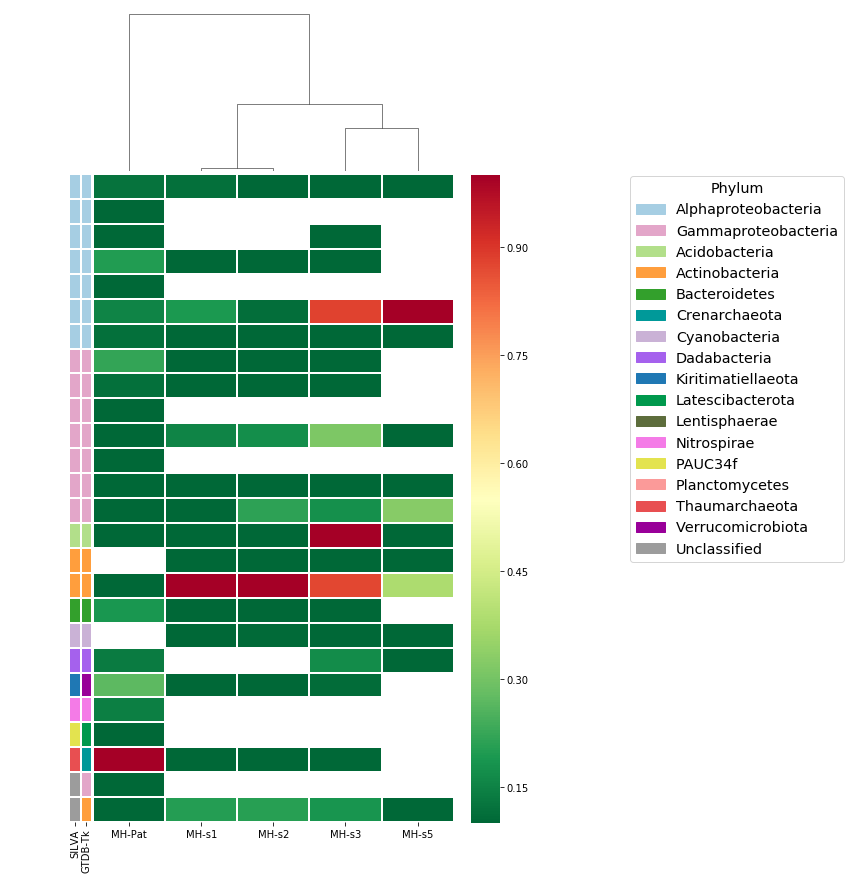

In [20]:


clst_map = sns.clustermap(heat_map_df_ord[['MH-Pat', 'MH-s1', 'MH-s2', 'MH-s3', 'MH-s5']],
               metric="correlation", 
               row_cluster=False,
               method="average", 
               cmap='RdYlGn_r', 
               row_colors = colors_df,
               vmin= 0.1,
               mask = masking==0,
               linewidths = 1,
               figsize = (8,15),
               yticklabels=False,
                          
             )



patchs = [mpatches.Patch(color=v, label=k) for k, v in color_map.items()]

legend = plt.legend(handles=patchs,bbox_to_anchor=(13.2, 1.01), title="Phylum", fontsize='x-large')
plt.setp(legend.get_title(),fontsize='x-large')
clst_map.cax.set_position([0.93, .124, .05, .6])



##[left, bottom, width, height]

clst_map.savefig('clust_map_phylo.png', dpi = 600)
